In [1]:
pip install pillow opencv-python numpy nltk matplotlib pandas

In [2]:
import os
import random
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import nltk
from nltk.corpus import words
from matplotlib import font_manager
import pandas as pd

# Download the NLTK words corpus (if not already downloaded)
nltk.download('words', quiet=True)

# ---------------------------
# Utility functions
# ---------------------------

def get_random_word(min_len=5, max_len=10):
    """
    Returns a random word from the NLTK words corpus that is all alphabetic
    and whose length is between min_len and max_len.
    """
    word_list = [w for w in words.words() if w.isalpha() and min_len <= len(w) <= max_len]
    return random.choice(word_list)

def get_system_fonts():
    """
    Returns a list of system TrueType font file paths using matplotlib's font_manager.
    """
    font_paths = font_manager.findSystemFonts(fontpaths="/content/drive/MyDrive/Google_Webfonts_Package", fontext='ttf')
    # If no fonts are found, we will rely on PIL's default font.
    return font_paths if font_paths else []

def random_capitalization(word):
    """
    Returns the word with randomly assigned capitalization for each letter.
    """
    return ''.join(c.upper() if random.random() < 0.5 else c.lower() for c in word)

def create_noisy_background(image_size, background_color=None, sigma=20):
    """Creates a noisy background image with Gaussian noise."""
    # Create a blank image with the desired size
    background = Image.new('RGB', image_size, color=background_color)
    # Add Gaussian noise to the background image
    noisy_background = add_noise_to_image(background, sigma=sigma)
    return noisy_background

def add_noise_to_image(pil_image, sigma=10):
    """
    Adds Gaussian noise to the image using OpenCV.
    """
    image_np = np.array(pil_image)
    # Create Gaussian noise
    noise = np.random.normal(0, sigma, image_np.shape).astype(np.uint8)
    noisy_image = cv2.add(image_np, noise)
    return Image.fromarray(noisy_image)

def generate_text_image(word, font_path, image_size=(128, 64), text_color=None,
                        background_color=None, reverse=False, use_noisy_background=False):
    """
    Generates an image with the given word rendered on it.
    - If reverse is True, the text is drawn in reverse order.
    - If text_color or background_color is None, random colors are chosen.
    - A random font size is also selected.
    """
    padding=10
    # Set default or random colors if not provided.
    if background_color is None:
        # Choose a light background color
        background_color = tuple(random.randint(200, 255) for _ in range(3))
    if text_color is None:
        # Choose a dark text color
        text_color = tuple(random.randint(0, 50) for _ in range(3))

    # Reverse the word if needed.
    display_text = word[::-1] if reverse else word

    # Create a blank image
    if use_noisy_background:
           image = create_noisy_background(image_size, background_color, sigma=20)
    else:
           image = Image.new('RGB', image_size, color=background_color)

    draw = ImageDraw.Draw(image)

    # Determine the maximum font size that will allow the text to fit.
    max_font_size = 40
    min_font_size = 10
    font_size = max_font_size

    # Loop to reduce the font size until the text fits with some padding.
    while font_size >= min_font_size:
       try:
         font = ImageFont.truetype(font_path, font_size)
       except Exception:
         font = ImageFont.load_default()
         break

       text_bbox = draw.textbbox((0, 0), display_text, font=font)  # Get bounding box
       text_width = text_bbox[2] - text_bbox[0]
       text_height = text_bbox[3] - text_bbox[1]

       if text_width <= image_size[0] - padding and text_height <= image_size[1] - padding:
          break

       font_size -= 1

# Ensure a minimum font size
    if font_size < min_font_size:
       font_size = min_font_size
       font = ImageFont.truetype(font_path, font_size)
       text_bbox = draw.textbbox((0, 0), display_text, font=font)
       text_width = text_bbox[2] - text_bbox[0]
       text_height = text_bbox[3] - text_bbox[1]

    # Get text size and compute position for centering
    text_bbox = draw.textbbox((0, 0), display_text, font=font)
    text_width = text_bbox[2] - text_bbox[0]  # width is right - left
    text_height = text_bbox[3] - text_bbox[1] # height is bottom - top
    position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)

    # Draw the text onto the image
    draw.text(position, display_text, fill=text_color, font=font)
    return image

# ---------------------------
# Dataset Generation Functions
# ---------------------------

def generate_easy_sample(image_size=(128, 64)):
    """
    Easy Set:
      - Uses a random word (kept in its original capitalization).
      - Uses a fixed plain white background.
      - Uses a randomly selected system font.
    """
    word = get_random_word()
    # For easy set, we fix the background to white and text color to black.
    background_color = (255, 255, 255)
    text_color = (0, 0, 0)
    # fonts = get_system_fonts()
    font_path = "/content/drive/MyDrive/Google_Webfonts_Package/Adamina-Regular.ttf"
    # Use the original word without random capitalization.
    image = generate_text_image(word, font_path, image_size,
                                text_color=text_color,
                                background_color=background_color,
                                reverse=False)
    return image, word

def generate_hard_sample(image_size=(128, 64)):
    """
    Hard Set:
      - Uses a random word with random per-letter capitalization.
      - Uses a random background color (not fixed white) and random text color.
      - Uses a randomly selected system font.
      - Adds Gaussian noise to simulate a noisy environment.
    """
    word = get_random_word()
    word = random_capitalization(word)
    # Random background: light color
    background_color = tuple(random.randint(200, 255) for _ in range(3))
    # Random text color: dark color
    text_color = tuple(random.randint(0, 50) for _ in range(3))
    fonts = get_system_fonts()
    font_path = random.choice(fonts) if fonts else None
    image = generate_text_image(word, font_path, image_size,
                                text_color=text_color,
                                background_color=background_color,
                                reverse=False,
                                use_noisy_background=True)
    # Add noise to the image
    # noisy_image = add_noise_to_image(image, sigma=random.randint(5, 20))
    return image, word

def generate_bonus_sample(image_size=(128, 64)):
    """
    Bonus Set:
      - Uses all the variations of the hard set.
      - If the background is red, then the text is rendered reversed,
        but the ground truth remains the original word.
      - Otherwise, it is rendered normally.
      - Background color is chosen randomly between a red-ish and green-ish color.
    """
    word = get_random_word()
    # Randomly decide on background color: red-ish or green-ish.
    red_background = (255, random.randint(0, 50), random.randint(0, 50))
    green_background = (random.randint(0, 50), 255, random.randint(0, 50))
    background_color = random.choice([red_background, green_background])
    # Determine whether to reverse text based on background.
    reverse = (background_color[0] == 255)  # if red background, then reverse.
    # Random text and random font
    text_color = tuple(random.randint(0, 50) for _ in range(3))
    fonts = get_system_fonts()
    font_path = random.choice(fonts) if fonts else None
    # For added difficulty, apply random capitalization.
    word_modified = random_capitalization(word)
    image = generate_text_image(word_modified, font_path, image_size,
                                text_color=text_color,
                                background_color=background_color,
                                reverse=reverse)
    # Optionally add noise here as well (using a lower sigma)
    # final_image = add_noise_to_image(image, sigma=random.randint(1, 3))
    # Ground truth remains the original word (not modified or reversed)
    return image, word

def save_image(image, label, output_dir, index, set_name):
    """
    Saves the image to the specified directory with a filename that includes the label.
    """
    os.makedirs(output_dir, exist_ok=True)
    filename = f"{set_name}_{index}_{label}.png"
    filepath = os.path.join(output_dir, filename)
    image.save(filepath)
    return filepath

def generate_dataset_csv(num_samples=50, image_size=(128, 64)):
    """
    Generates three datasets (easy, hard, bonus), saves each image, and creates a CSV file
    that records (set, image_path, label) for every sample.
    """
    base_dir = "dataset"
    os.makedirs(base_dir, exist_ok=True)

    # Dictionary mapping set names to their generator functions.
    generators = {
        # "easy": generate_easy_sample,
        # "hard": generate_hard_sample
        "bonus": generate_bonus_sample
    }

    # List to hold rows for the CSV.
    data_rows = []

    # For each set, generate samples and record image path and label.
    for set_name, generator in generators.items():
        output_dir = os.path.join(base_dir, set_name)
        for i in range(num_samples):
            image, label = generator(image_size=image_size)
            img_path = save_image(image, label, output_dir, i, set_name)
            data_rows.append({
                "set": set_name,
                "image_path": img_path,
                "label": label
            })
            print(f"Saved {set_name} sample {i}: {label}")

    # Create a DataFrame and write to CSV.
    df = pd.DataFrame(data_rows)
    csv_path = os.path.join(base_dir, "dataset.csv")
    df.to_csv(csv_path, index=False)
    print(f"CSV file saved at {csv_path}")

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    NUM_SAMPLES = 10000  # Change as desired
    IMAGE_SIZE = (128, 64)

    generate_dataset_csv(num_samples=NUM_SAMPLES, image_size=IMAGE_SIZE)
    print("Dataset generation complete.")

Streaming output truncated to the last 5000 lines.
Saved bonus sample 5002: interteam
Saved bonus sample 5003: transport
Saved bonus sample 5004: stagese
Saved bonus sample 5005: tripple
Saved bonus sample 5006: scriggler
Saved bonus sample 5007: chonolith
Saved bonus sample 5008: overproud
Saved bonus sample 5009: muddily
Saved bonus sample 5010: supellex
Saved bonus sample 5011: paradisian
Saved bonus sample 5012: queersome
Saved bonus sample 5013: kooka
Saved bonus sample 5014: roadless
Saved bonus sample 5015: runrig
Saved bonus sample 5016: Munnopsis
Saved bonus sample 5017: preboyhood
Saved bonus sample 5018: beaver
Saved bonus sample 5019: abacate
Saved bonus sample 5020: undigested
Saved bonus sample 5021: urinalist
Saved bonus sample 5022: lifeward
Saved bonus sample 5023: diallagite
Saved bonus sample 5024: hirtellous
Saved bonus sample 5025: Kristinaux
Saved bonus sample 5026: serin
Saved bonus sample 5027: psychid
Saved bonus sample 5028: pellety
Saved bonus sample 5029: pl

In [3]:
import pandas as pd

# Define the path to your CSV file
csv_path = './dataset/dataset.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Convert the 'label' column to lowercase
df['label'] = df['label'].str.lower()

# Save the updated DataFrame back to CSV (overwriting the original file)
df.to_csv(csv_path, index=False)

print("All labels have been converted to lowercase and saved.")


All labels have been converted to lowercase and saved.


In [4]:
pip install torch torchvision pandas pillow matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Total bonus samples: 10000
Training samples: 8000 Test samples: 2000
CRNNResidual(
  (block1): ResidualBlock(
    (activation): ReLU()
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_skip): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_skip): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (block2): ResidualBlock(
    (activation): ReLU()
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3)

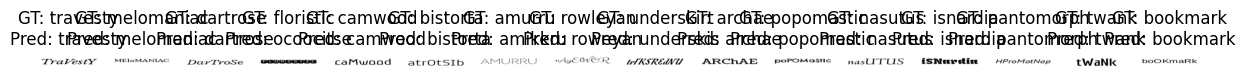

In [5]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETUP
# ---------------------------
CSV_PATH = './dataset/dataset.csv'
BATCH_SIZE = 16
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Our CRNN model expects input images of shape (channels, height, width) = (1, 32, 128)
IMAGE_SIZE = (32, 128)  # (height, width)

# Define our character set: bonus set is assumed to contain only lowercase a-z.
LETTERS = "abcdefghijklmnopqrstuvwxyz"
char_to_idx = {char: i+1 for i, char in enumerate(LETTERS)}
idx_to_char = {i+1: char for i, char in enumerate(LETTERS)}
blank_idx = 0
num_classes = len(LETTERS) + 1  # plus the blank token

# ---------------------------
# DATASET FOR BONUS SET WITH BACKGROUND-BASED LABEL INVERSION
# ---------------------------
class OCRBonusDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Must contain columns "set", "image_path", "label".
            transform (callable, optional): Transformation to apply on the grayscale image.
        """
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["image_path"]
        true_label = row["label"].strip().lower()  # forward (correct) word
        set_name = row["set"].strip().lower()       # should be "bonus"

        # Open the image in RGB for background analysis.
        try:
            img_rgb = Image.open(img_path).convert("RGB")
        except Exception as e:
            print("Error opening image:", img_path)
            raise e

        # Compute average color over the image.
        img_np = np.array(img_rgb)  # shape (H, W, 3)
        avg_R = np.mean(img_np[:,:,0])
        avg_G = np.mean(img_np[:,:,1])
        # Simple heuristic: if average Red is higher than average Green, consider background red.
        bg_color = "red" if avg_R > avg_G else "green"

        # For training, define the effective label:
        # If background is red, reverse the label; if green, keep it as is.
        if bg_color == "red":
            effective_label = true_label[::-1]
        else:
            effective_label = true_label

        # Now open the image for model input in grayscale.
        try:
            img_gray = Image.open(img_path).convert("L")
        except Exception as e:
            print("Error opening image as grayscale:", img_path)
            raise e
        if self.transform:
            img_transformed = self.transform(img_gray)
        else:
            img_transformed = img_gray  # should be a tensor

        # Encode the effective label (the one used for training) using char_to_idx.
        label_encoded = [char_to_idx[c] for c in effective_label]
        label_length = len(label_encoded)

        # Return the transformed image, the encoded (effective) label, the true forward label,
        # its length, and the background color.
        return img_transformed, torch.tensor(label_encoded, dtype=torch.long), true_label, label_length, bg_color

# Transformation: resize image to (32,128), convert to tensor, and normalize.
transform_bonus = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),   # (height, width)
    transforms.ToTensor(),           # Grayscale image tensor: (1, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the CSV and filter for bonus set.
df = pd.read_csv(CSV_PATH)
df_bonus = df[df["set"].str.lower() == "bonus"].reset_index(drop=True)
print("Total bonus samples:", len(df_bonus))

dataset_bonus = OCRBonusDataset(df_bonus, transform=transform_bonus)

# We'll split the bonus dataset into training and test sets (e.g., 80% training, 20% test).
train_size = int(0.8 * len(dataset_bonus))
test_size = len(dataset_bonus) - train_size
train_dataset, test_dataset = random_split(dataset_bonus, [train_size, test_size])
print("Training samples:", len(train_dataset), "Test samples:", len(test_dataset))

# Custom collate function to handle variable-length targets.
def collate_fn_bonus(batch):
    images, labels, raw_labels, label_lengths, bg_colors = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(labels)
    target_lengths = torch.tensor(label_lengths, dtype=torch.long)
    return images, targets, target_lengths, raw_labels, bg_colors

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_bonus)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_bonus)

# ---------------------------
# MODEL DEFINITION: Residual Block and CRNNResidual (same as previous Task 3)
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, skip_conv, dropout=0.2, activation='relu'):
        """
        A residual block with two 3x3 convolutions and an optional skip convolution.
        """
        super(ResidualBlock, self).__init__()
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_conv = skip_conv
        if skip_conv:
            self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
            self.bn_skip = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.skip_conv:
            identity = self.conv_skip(identity)
            identity = self.bn_skip(identity)
        out += identity
        out = self.activation(out)
        out = self.dropout(out)
        return out

class CRNNResidual(nn.Module):
    def __init__(self, input_shape, output_dim, activation='relu', dropout=0.2):
        """
        CRNN model using residual blocks.
        input_shape: (channels, height, width) e.g. (1, 32, 128)
        output_dim: number of distinct characters (excluding the blank token)
        The model outputs logits of shape (sequence_length, batch, output_dim+1) for CTC loss.
        """
        super(CRNNResidual, self).__init__()
        # Residual blocks configuration (same as before).
        self.block1 = ResidualBlock(in_channels=input_shape[0], out_channels=16,
                                    stride=1, skip_conv=True, dropout=dropout, activation=activation)
        self.block2 = ResidualBlock(in_channels=16, out_channels=16,
                                    stride=2, skip_conv=True, dropout=dropout, activation=activation)
        self.block3 = ResidualBlock(in_channels=16, out_channels=16,
                                    stride=1, skip_conv=False, dropout=dropout, activation=activation)
        self.block4 = ResidualBlock(in_channels=16, out_channels=32,
                                    stride=2, skip_conv=True, dropout=dropout, activation=activation)
        self.block5 = ResidualBlock(in_channels=32, out_channels=32,
                                    stride=1, skip_conv=False, dropout=dropout, activation=activation)
        self.block6 = ResidualBlock(in_channels=32, out_channels=64,
                                    stride=1, skip_conv=True, dropout=dropout, activation=activation)
        self.block7 = ResidualBlock(in_channels=64, out_channels=64,
                                    stride=1, skip_conv=False, dropout=dropout, activation=activation)
        # After block7, output shape is (B, 64, H', W'). We flatten spatial dims into a sequence.
        self.blstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64 * 2, output_dim + 1)  # output_dim+1 classes (including blank)

    def forward(self, x):
        # x: (B, 1, 32, 128)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        B, C, H, W = x.size()  # Expect C == 64.
        # Flatten spatial dimensions: sequence length = H * W.
        x = x.view(B, C, H * W)
        x = x.permute(0, 2, 1)  # (B, seq_len, 64)
        x, _ = self.blstm(x)    # (B, seq_len, 128)
        x = self.fc(x)          # (B, seq_len, output_dim+1)
        x = x.permute(1, 0, 2)   # (seq_len, B, output_dim+1) for CTC loss
        return x

# Instantiate the CRNNResidual model.
# Input shape: (channels, height, width) = (1, 32, 128)
model_bonus = CRNNResidual(input_shape=(1, 32, 128), output_dim=len(LETTERS), activation='relu', dropout=0.2)
model_bonus = model_bonus.to(DEVICE)
print(model_bonus)

# ---------------------------
# LOSS FUNCTION AND OPTIMIZER
# ---------------------------
ctc_loss_fn = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
optimizer_bonus = optim.Adam(model_bonus.parameters(), lr=LEARNING_RATE)

# ---------------------------
# TRAINING LOOP
# ---------------------------
def train_model(model, dataloader, optimizer, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, targets, target_lengths, raw_labels, bg_colors in dataloader:
            images = images.to(device)  # images shape: (B, 1, 32, 128)
            targets = targets.to(device)
            batch_size = images.size(0)
            outputs = model(images)  # outputs: (T, B, num_classes)
            T = outputs.size(0)
            # All samples have T time steps.
            input_lengths = torch.full((batch_size,), T, dtype=torch.long).to(device)
            loss = criterion(outputs.log_softmax(2), targets, input_lengths, target_lengths.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    print("Training complete.")

train_model(model_bonus, train_loader, optimizer_bonus, ctc_loss_fn, NUM_EPOCHS, DEVICE)

# ---------------------------
# GREEDY DECODER
# ---------------------------
def greedy_decoder(output, blank=blank_idx):
    """
    Performs greedy decoding on the model output.
    Args:
      output: Tensor of shape (T, B, num_classes)
      blank: Index of the blank token.
    Returns:
      List of decoded strings (one per sample).
    """
    output = output.permute(1, 0, 2)  # (B, T, num_classes)
    decoded_texts = []
    for seq in output:
        _, max_indices = torch.max(seq, dim=1)  # (T,)
        prev_idx = blank
        decoded = []
        for idx in max_indices.cpu().numpy().tolist():
            if idx != blank and idx != prev_idx:
                decoded.append(idx)
            prev_idx = idx
        decoded_text = "".join([idx_to_char[i] for i in decoded])
        decoded_texts.append(decoded_text)
    return decoded_texts

# ---------------------------
# LEVENSHTEIN DISTANCE FUNCTION
# ---------------------------
def levenshtein_distance(s1, s2):
    m, n = len(s1), len(s2)
    dp = np.zeros((m+1, n+1), dtype=int)
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,
                           dp[i][j-1] + 1,
                           dp[i-1][j-1] + cost)
    return dp[m][n]

# ---------------------------
# EVALUATION FUNCTION
# ---------------------------
def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_words = 0
    total_edit_distance = 0
    total_chars = 0
    all_decoded = []
    all_ground_truths = []
    with torch.no_grad():
        for images, targets, target_lengths, raw_labels, bg_colors in dataloader:
            images = images.to(device)
            outputs = model(images)  # (T, B, num_classes)
            decoded_texts = greedy_decoder(outputs, blank=blank_idx)
            # For each sample, check its background color and adjust the predicted text.
            adjusted_texts = []
            for pred, bg in zip(decoded_texts, bg_colors):
                # For bonus images, if bg_color is red, reverse the prediction to get the forward word.
                if bg == "red":
                    adjusted_texts.append(pred[::-1])
                else:
                    adjusted_texts.append(pred)
            all_decoded.extend(adjusted_texts)
            all_ground_truths.extend(raw_labels)
            for pred, gt in zip(adjusted_texts, raw_labels):
                total_samples += 1
                if pred.lower() == gt.lower():
                    correct_words += 1
                distance = levenshtein_distance(pred.lower(), gt.lower())
                total_edit_distance += distance
                total_chars += len(gt)
    word_accuracy = correct_words / total_samples if total_samples > 0 else 0.0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0.0
    print(f"Test Set Word Accuracy: {word_accuracy * 100:.2f}%")
    print(f"Average Levenshtein Distance: {total_edit_distance / total_samples:.2f}")
    print(f"Character Error Rate (CER): {cer * 100:.2f}%")
    return all_decoded, all_ground_truths, word_accuracy, cer

predicted_texts, ground_truth_texts, word_acc, cer = evaluate_model(model_bonus, test_loader, DEVICE)

print("\nSome example predictions on the test set:")
for gt, pred in zip(ground_truth_texts[:10], predicted_texts[:10]):
    print(f"Ground Truth: {gt}\t Predicted: {pred}")

# ---------------------------
# VISUALIZATION: DISPLAY A FEW TEST IMAGES WITH PREDICTIONS
# ---------------------------
def denormalize_image(tensor_img):
    # Reverse the normalization: x = (x * std) + mean.
    tensor_img = tensor_img * 0.5 + 0.5
    np_img = tensor_img.squeeze().cpu().numpy()
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)

model_bonus.eval()
with torch.no_grad():
    for images, targets, target_lengths, raw_labels, bg_colors in test_loader:
        images = images.to(DEVICE)
        outputs = model_bonus(images)  # (T, B, num_classes)
        decoded_texts = greedy_decoder(outputs, blank=blank_idx)
        # Adjust predictions based on background color.
        adjusted_texts = []
        for pred, bg in zip(decoded_texts, bg_colors):
            if bg == "red":
                adjusted_texts.append(pred[::-1])
            else:
                adjusted_texts.append(pred)
        pil_images = [denormalize_image(img) for img in images]
        num_examples = len(pil_images)
        plt.figure(figsize=(15, 3 * num_examples))
        for i, (img, gt, pred) in enumerate(zip(pil_images, raw_labels, adjusted_texts)):
            plt.subplot(1, num_examples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"GT: {gt}\nPred: {pred}")
            plt.axis("off")
        plt.show()
        break  # Show only the first batch


Train Set Word Accuracy: 89.91%
Average Levenshtein Distance: 0.38
Character Error Rate (CER): 4.77%

Some example predictions on the train set:
Ground Truth: nitrosyl	 Predicted: nitrosyl
Ground Truth: plumular	 Predicted: plumular
Ground Truth: nugify	 Predicted: nugify
Ground Truth: cajeput	 Predicted: cajeput
Ground Truth: unpicked	 Predicted: unpicked
Ground Truth: coeducate	 Predicted: coeducate
Ground Truth: unanalytic	 Predicted: unanalytic
Ground Truth: turmoiler	 Predicted: turmoiler
Ground Truth: collect	 Predicted: collect
Ground Truth: boother	 Predicted: boother


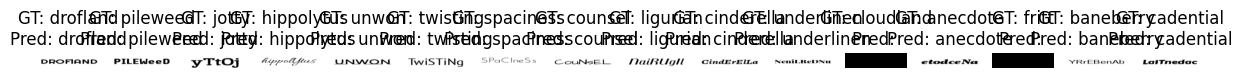

In [6]:
# ---------------------------
# EVALUATION FUNCTION
# ---------------------------
def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_words = 0
    total_edit_distance = 0
    total_chars = 0
    all_decoded = []
    all_ground_truths = []
    with torch.no_grad():
        for images, targets, target_lengths, raw_labels, bg_colors in dataloader:
            images = images.to(device)
            outputs = model(images)  # (T, B, num_classes)
            decoded_texts = greedy_decoder(outputs, blank=blank_idx)
            # For each sample, check its background color and adjust the predicted text.
            adjusted_texts = []
            for pred, bg in zip(decoded_texts, bg_colors):
                # For bonus images, if bg_color is red, reverse the prediction to get the forward word.
                if bg == "red":
                    adjusted_texts.append(pred[::-1])
                else:
                    adjusted_texts.append(pred)
            all_decoded.extend(adjusted_texts)
            all_ground_truths.extend(raw_labels)
            for pred, gt in zip(adjusted_texts, raw_labels):
                total_samples += 1
                if pred.lower() == gt.lower():
                    correct_words += 1
                distance = levenshtein_distance(pred.lower(), gt.lower())
                total_edit_distance += distance
                total_chars += len(gt)
    word_accuracy = correct_words / total_samples if total_samples > 0 else 0.0
    cer = total_edit_distance / total_chars if total_chars > 0 else 0.0
    print(f"Train Set Word Accuracy: {word_accuracy * 100:.2f}%")
    print(f"Average Levenshtein Distance: {total_edit_distance / total_samples:.2f}")
    print(f"Character Error Rate (CER): {cer * 100:.2f}%")
    return all_decoded, all_ground_truths, word_accuracy, cer

predicted_texts, ground_truth_texts, word_acc, cer = evaluate_model(model_bonus, train_loader, DEVICE)

print("\nSome example predictions on the train set:")
for gt, pred in zip(ground_truth_texts[:10], predicted_texts[:10]):
    print(f"Ground Truth: {gt}\t Predicted: {pred}")

# ---------------------------
# VISUALIZATION: DISPLAY A FEW TEST IMAGES WITH PREDICTIONS
# ---------------------------
def denormalize_image(tensor_img):
    # Reverse the normalization: x = (x * std) + mean.
    tensor_img = tensor_img * 0.5 + 0.5
    np_img = tensor_img.squeeze().cpu().numpy()
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)

model_bonus.eval()
with torch.no_grad():
    for images, targets, target_lengths, raw_labels, bg_colors in train_loader:
        images = images.to(DEVICE)
        outputs = model_bonus(images)  # (T, B, num_classes)
        decoded_texts = greedy_decoder(outputs, blank=blank_idx)
        # Adjust predictions based on background color.
        adjusted_texts = []
        for pred, bg in zip(decoded_texts, bg_colors):
            if bg == "red":
                adjusted_texts.append(pred[::-1])
            else:
                adjusted_texts.append(pred)
        pil_images = [denormalize_image(img) for img in images]
        num_examples = len(pil_images)
        plt.figure(figsize=(15, 3 * num_examples))
        for i, (img, gt, pred) in enumerate(zip(pil_images, raw_labels, adjusted_texts)):
            plt.subplot(1, num_examples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"GT: {gt}\nPred: {pred}")
            plt.axis("off")
        plt.show()
        break  # Show only the first batch


In [7]:
torch.save(model_bonus, "model_bonus.pth")